<a href="https://colab.research.google.com/github/nsharan2000/image-caption-generator/blob/main/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the main project code for IITK ML and AI internship

Team: savvy captioners

-->Sharan Nagarajan

-->RKP Ghanashyam

-->Bala Murugan

Flickr8k Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the necessary libraries and datasets

In [ ]:
#tensorflow  library is used in our model
import tensorflow as tf

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import string
import re
import os
import time
import json
from PIL import Image

## Image and dataset path is loaded

In [ ]:
# the image directory contains all the images
# image directory path
image_dir = 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset'
# image_dir = '/content/drive/My Drive/flickr8k_dataset/Flickr_Data/Flickr_Data/Images'
images = os.listdir(image_dir)
#to filter out .npy files that we created in the same folder

#since we save .npy and .jpg images in the same folder, we are filtering out the .npy files while calculating the leghth of image_list
images=[i for i in images if i[-4:]!='.npy']

#the flickr8k.token.txt file contains the captions for the corresponiding text files in a particular format
# caption annotation file path
descriptions_dir = 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_text\\Flickr8k.token.txt'
#descriptions_dir = '/content/drive/My Drive/flickr8k_dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
print(f"The number of jpg flies in Flicker8k: {len(images)}")
print(images[:5])

The number of jpg flies in Flicker8k: 8091
['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg']


## Text data processing pipeline

In [ ]:
# loading the document
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# read in the Flickr caption data
text = load_doc(descriptions_dir)
print(text[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


From the text sentence above we can see that the data is arranged in a particular format for the flickr8k dataset, hence we need to process the data before we could create a dataframe that is suitable to be passed as an tensorflow tensor

In [ ]:
def create_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split('\t')
      if len(splitted) == 1:
          continue
      w = splitted[0].split("#")
      df.append(w + [splitted[1].lower()])
  return df

In [ ]:
df = create_dataset(text)

In [ ]:
#reading the data as a pandas dataframe
data = pd.DataFrame(df,columns=["filename","index","caption"])
# Reordering the index
data = data.reindex(columns =['index','filename','caption'])

In [ ]:
#the first 5 elements of the dataframe created
data.head()

index                   filename  \
0     0  1000268201_693b08cb0e.jpg   
1     1  1000268201_693b08cb0e.jpg   
2     2  1000268201_693b08cb0e.jpg   
3     3  1000268201_693b08cb0e.jpg   
4     4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...

In [ ]:
#find invalid files
def check_file(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))
check_file(data)

Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1


In [ ]:
#we need to remove all these invalid files
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
print('shape of dataframe with valid files:',data.shape)

shape of dataframe with valid files: (40455, 3)


In [ ]:
def create_vocabulary(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [ ]:
vocabulary = create_vocabulary(data)

Vocabulary Size : 8918


For the model to work more efficiently, we have removed unwanted punctuations , single characters and numericals from the generated captions. Therefore only whole words are passed onto the model

In [ ]:

def text_clean(text_original):
  #remove punctuations
  text_no_punctuation = text_original.translate(string.punctuation)

  #remove single characters
  text=text_no_punctuation
  text_len_more_than1 = ""
  for word in text.split():
    if len(word) > 1:
        text_len_more_than1 += " " + word
            
  #remove numericals
  text = text_len_more_than1
  text_no_numeric = ""
  for word in text.split():
      isalpha = word.isalpha()
      if isalpha:
          text_no_numeric += " " + word
  text = text_no_numeric
  return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = create_vocabulary(data)

Vocabulary Size : 8357


In [ ]:
def preprocess_images(data):
  image_list = []

  for filenames in data["filename"]:
      full_image_path = image_dir+"/"+ filenames
      image_list.append(full_image_path)
  return image_list
image_list = preprocess_images(data)
#image_list[:10]

In [ ]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data["caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
#total_captions[:10]

In [ ]:
ten_images = image_list[:50] # Each image repeats 5 times in dataset
unique_images = np.unique(ten_images)
#print(unique_images)

In [ ]:
print("Total Images : " + str(len(image_list)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40455
Total Captions : 40455


From the above cell it is clear that the number of images in the dataset is greater than 8000. This is because the each image in the dataset is mapped to five of its captions 

In [ ]:
print(image_list[:10])
print(total_captions[:10])

['D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'D:\\Dataset\\utorrent\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg']
['<start>  child in

In [ ]:
def data_limiter(num,total_captions,image_list):
  # Shuffle captions and image_names together
  train_captions, image_list_final = shuffle(total_captions,image_list,random_state=1)
  train_captions = train_captions[:num]
  image_list_final = image_list_final[:num]
  return train_captions,image_list_final

In [ ]:
train_captions,image_list_final = data_limiter(40000,total_captions,image_list)

In [ ]:
print(f"Total Captions = {len(train_captions)} , Total images = {len(image_list_final)}")

Total Captions = 40000 , Total images = 40000


Shape of the image:(500, 375, 3)


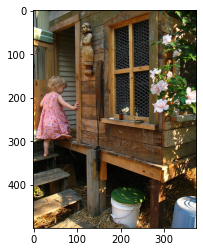

In [ ]:
#inorder to process the image within the inception we need to resize it into the correct shape
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print(f"Shape of the image:{img.shape}")

image_and_shapes(image_dir+ '/1000268201_693b08cb0e.jpg')

### Loading image as encoded

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

encode_image = tf.keras.Model(new_input, hidden_layer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


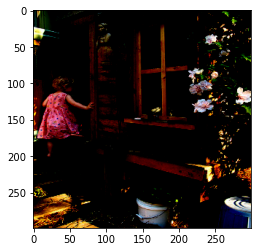

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

img1,img1_path = load_image(image_dir+ "/1000268201_693b08cb0e.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)
#the image color is also changed because it is preprocessed as inception v3 model would take it

In [ ]:
# Get unique images
uniquelist = sorted(set(image_list_final))
batch_size=16

#image_dataset is loaded
image_dataset = tf.data.Dataset.from_tensor_slices(uniquelist)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)


In [ ]:
#run this file only  one time as you need to save the encoded images only once 
# i=0
# for img, path in image_dataset:
#   i+=1
#   batch_features = encode_image(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))
#   if(i%50==1): print('completed: ',i)
#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())




## Preprocess and tokenize the captions

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [ ]:
# 80-20 split of training and validation
img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_list_final,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
                                                                  

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

## Create a tf.data dataset for training


Now that our images and captions, let's create a tf.data dataset to use for training our model.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
#the final vector from inception v3 is off the shape (64,2048)
#these weights are represented ads feature shape and attention shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
#loading the saved numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
#dataset in sthe training dataset tensor
#validationset is the validation dataset tensor
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
validationset=tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
 
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda i1, i2: tf.numpy_function(
          map_func, [i1, i2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

validationset = validationset.map(lambda i1, i2: tf.numpy_function(
          map_func, [i1, i2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
 
# Shuffle and batch
validationset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
 
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validationset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model


In [ ]:
#the pretrained encoder gives the encoded image, this model is used to pass the encoded image through a single dense layer before passing onto the encoder
class EncoderInterface(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(EncoderInterface, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class SimpleAttention(tf.keras.Model):
  def __init__(self, units):
    super(SimpleAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features (shape) (EncoderInterface output)= (batch_size, 64, embedding_dim)

    # hidden (shape)=(batch_size, hidden_size)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # hidden_with_time_axis (shape)= (batch_size, 1, hidden_size)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    # score shape= (batch_size, 64, hidden_size)

    # attention_weights shape= (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    #attention weights is multiplied elementwise over all the features
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # context_vector shape after sum= (batch_size, hidden_size)

    return context_vector, attention_weights

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    #GRU units are used as recurrent neural networks

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = SimpleAttention(self.units)
  
  #the RNN model is implemented as an custom tensorflow function
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    #x is passed through embeddings
    x = self.embedding(x)
    #x shape (batch_size, 1, embedding_dim)

    # x is concatenated with context vector and a new dimension
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    #x shape (batch_size, 1, embedding_dim + hidden_size)

    # concatenated vector is passed through GRU which producese output and state
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = EncoderInterface(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
#we use adam optimizer for best results
optimizer = tf.keras.optimizers.Adam()
#sparse categorical crossentroppy loss function is uses
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss*= mask

  return tf.reduce_mean(loss)

## Checkpoint

In [ ]:
# checkpoint_path = "/content/drive/My Drive/flickr8k_dataset/checkpoints_inceptionv3/train"
checkpoint_path = "./checkpoints_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  #as checkpoint is saved once every 5 epochs we multiply the latest checkpoint number by 5
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])*5
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_loss_plot=[]

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image, we reset the decoder states
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  #gradient descent is applied to the trainable variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
@tf.function
def val_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image, we reset the decoder states
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  return loss, total_loss

In [ ]:
EPOCHS = 30
 
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    totalval_loss=0
 
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
 
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
 
    for (batch, (img_tensor, target)) in enumerate(validationset):
        batchval_loss, t_loss = val_step(img_tensor, target)
        totalval_loss += t_loss
 
    # storing the validation epoch end loss value to plot later
    val_loss_plot.append(totalval_loss / num_steps)
 
    if epoch % 5 == 0:
      ckpt_manager.save()
 
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print('validation loss : ',totalval_loss/num_steps)
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6291
Epoch 1 Batch 100 Loss 1.5693
Epoch 1 Batch 200 Loss 1.2788
Epoch 1 Batch 300 Loss 1.3629
Epoch 1 Batch 400 Loss 1.1700
Epoch 1 Loss 1.403265
validation loss :  tf.Tensor(1.1489289, shape=(), dtype=float32)
Time taken for 1 epoch 356.2718560695648 sec

Epoch 2 Batch 0 Loss 1.0813
Epoch 2 Batch 100 Loss 1.1539
Epoch 2 Batch 200 Loss 1.2294
Epoch 2 Batch 300 Loss 1.1948
Epoch 2 Batch 400 Loss 1.1348
Epoch 2 Loss 1.112073
validation loss :  tf.Tensor(1.0110648, shape=(), dtype=float32)
Time taken for 1 epoch 113.592782497406 sec

Epoch 3 Batch 0 Loss 0.9282
Epoch 3 Batch 100 Loss 1.0125
Epoch 3 Batch 200 Loss 1.0969
Epoch 3 Batch 300 Loss 0.9647
Epoch 3 Batch 400 Loss 0.9283
Epoch 3 Loss 1.012155
validation loss :  tf.Tensor(0.9335887, shape=(), dtype=float32)
Time taken for 1 epoch 119.52442574501038 sec

Epoch 4 Batch 0 Loss 0.9361
Epoch 4 Batch 100 Loss 0.9314
Epoch 4 Batch 200 Loss 0.9438
Epoch 4 Batch 300 Loss 0.9191
Epoch 4 Batch 400 Loss 0.8381
Epoch 4 L

Epoch 30 Batch 0 Loss 0.3785
Epoch 30 Batch 100 Loss 0.2856
Epoch 30 Batch 200 Loss 0.3009
Epoch 30 Batch 300 Loss 0.2597
Epoch 30 Batch 400 Loss 0.2944
Epoch 30 Loss 0.286113
validation loss :  tf.Tensor(0.4717217, shape=(), dtype=float32)
Time taken for 1 epoch 119.58858275413513 sec



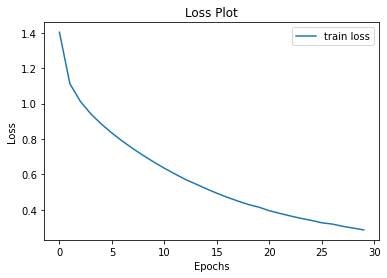

In [ ]:
plt.plot(loss_plot,label='train loss')
#plt.plot(val_loss_plot, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()

plt.show()

## Caption!


In [ ]:
#predict the captions for the image we have provided
#input :image path 
#output:numpy array of attention plots
def getcaption(image):
    plot_attention = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = encode_image(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    caption_generated = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        plot_attention[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        caption_generated.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return caption_generated, plot_attention

        dec_input = tf.expand_dims([predicted_id], 0)

    plot_attention = plot_attention[:len(caption_generated), :]
    return caption_generated, plot_attention

In [ ]:
#plots the attention plot
#plt.tight_layout automatically resizes the images for better readability
def plot(image, caption_generated, plot_attention):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_caption_generated = len(caption_generated)
    for l in range(len_caption_generated):
        temp_att = np.resize(plot_attention[l], (8, 8))
        ax = fig.add_subplot(len_caption_generated//2, len_caption_generated//2, l+1)
        ax.set_title(caption_generated[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> woman wearing white hat is carrying baby whilst shopping in market for groceries <end>
Prediction Caption: woman in white hat holding bags <end>


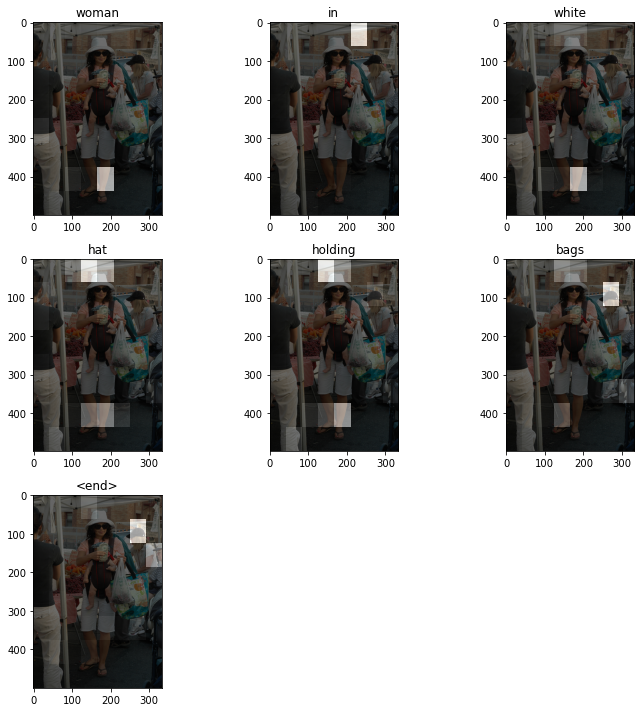

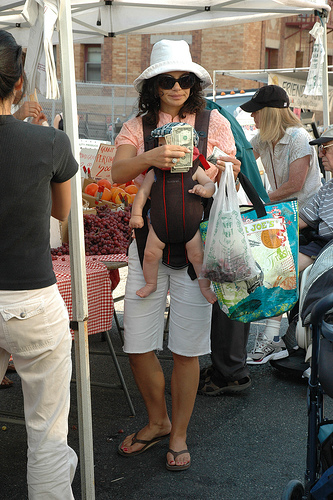

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption_generated, plot_attention = getcaption(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(caption_generated))
plot(image, caption_generated, plot_attention)
Image.open(image)


# Testing the accuracy with bleu  score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
#print(img_name_val,cap_val)
c=0
bleuadd=bleu1add=bleu2add=bleu3add=bleu4add=0
print('name val len=',len(img_name_val))
print('cap_val',len(cap_val))
#since the dataset is too small we use the first 500 images of the validation set for testing
img_name_test=img_name_val[:500]
cap_test=cap_val[:500]
for (image_path,tokensentence) in zip(img_name_test,cap_test):
  target=[]
  caption_generated, _ = getcaption(image_path)
  for i in tokensentence:
    if tokenizer.index_word[i] not in ('<pad>','<start>','<end>','<unk>') :
      target.append(tokenizer.index_word[i])
  reference=[caption_generated[:-1]]
  candidate=target
  bleu=sentence_bleu(reference, candidate)
  bleuadd+=bleu
  bleu1=sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
  bleu1add+=bleu1
  bleu2=sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
  bleu2add+=bleu2
  bleu3=sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
  bleu3add+=bleu3
  bleu4=sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))
  bleu4add+=bleu4
  c +=1
  if c%100==1:
    print('check: c=',c)
    print('reference=',reference)
    print('target=',candidate)
    print('bleu=',bleu)
bleu1final=bleu1add/c
bleu2final=bleu2add/c
bleu3final=bleu3add/c
bleu4final=bleu4add/c
bleufinal=bleuadd/c
print('average 1gram bleu score: ',bleu1final)
print('average 2gram bleu score: ',bleu2final)
print('average 3gram bleu score: ',bleu3final)
print('average 4gram bleu score: ',bleu4final)
print('final bleu score: ',bleufinal)

name val len= 8000
cap_val 8000
check: c= 1
reference= [['little', 'boy', 'wearing', '<unk>', 'of', 'finger', 'of', 'food']]
target= ['child', 'in', 'blue', 'shirt', 'smiles', 'about', 'what', 'in', 'his', 'hand']
bleu= 0


C:\Users\Hp\anaconda3\envs\tf-gpu-cuda10\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Hp\anaconda3\envs\tf-gpu-cuda10\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Hp\anaconda3\envs\tf-gpu-cuda10\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower 

check: c= 101
reference= [['boat', 'has', 'just', 'through', 'the', 'yellow', 'boat', 'behind']]
target= ['speedboat', 'through', 'the', 'water']
bleu= 3.506226123743032e-155
check: c= 201
reference= [['dog', 'playing', 'with', 'ball', 'in', 'the', 'dirt']]
target= ['dog', 'jumps', 'for', 'yellow', 'and', 'black', 'ball']
bleu= 1.331960397810445e-231
check: c= 301
reference= [['two', 'babies', 'make', 'an', 'obstacle', 'course', 'with', 'toys', 'mat']]
target= ['two', 'toddlers', 'are', 'sitting', 'in', 'colorful', 'playpen']
bleu= 8.416851712392762e-232
check: c= 401
reference= [['dog', 'runs', 'across', 'the', 'air']]
target= ['tan', 'dog', 'leaping', 'in', 'grassy', 'field']
bleu= 1.1640469867513693e-231
average 1gram bleu score:  0.1988900758416958
average 2gram bleu score:  0.052625827098893636
average 3gram bleu score:  0.01689325368318005
average 4gram bleu score:  0.005878165769577113
final bleu score:  0.008854687515522356


Testing with our own images!

Prediction Caption: man with purple is doing jump on the beach <end>


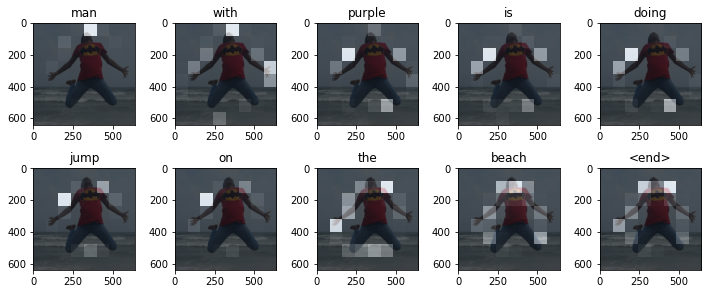

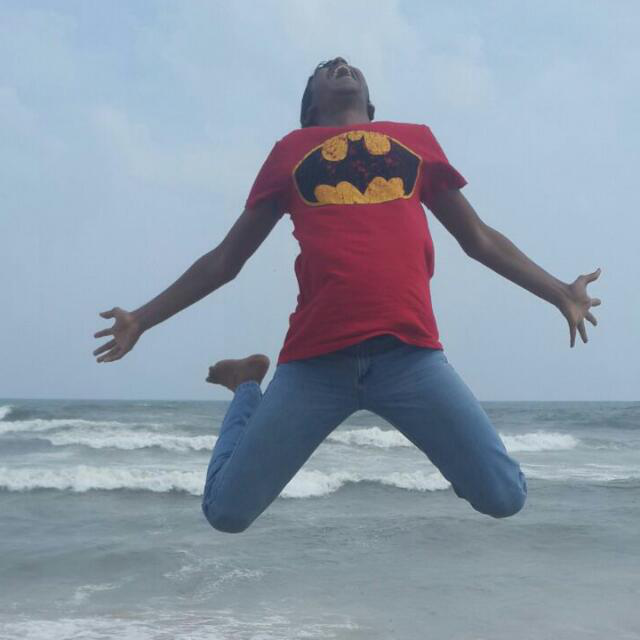

In [ ]:
image_path='C:/Users/Hp/python/sharan.jpg'
caption_generated, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(caption_generated))
plot(image_path, caption_generated, plot_attention)
# opening the image
Image.open(image_path)

Prediction Caption: man with glasses standing in grassy field with nearby <end>


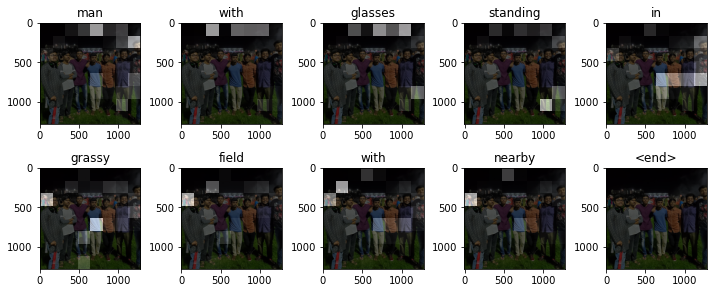

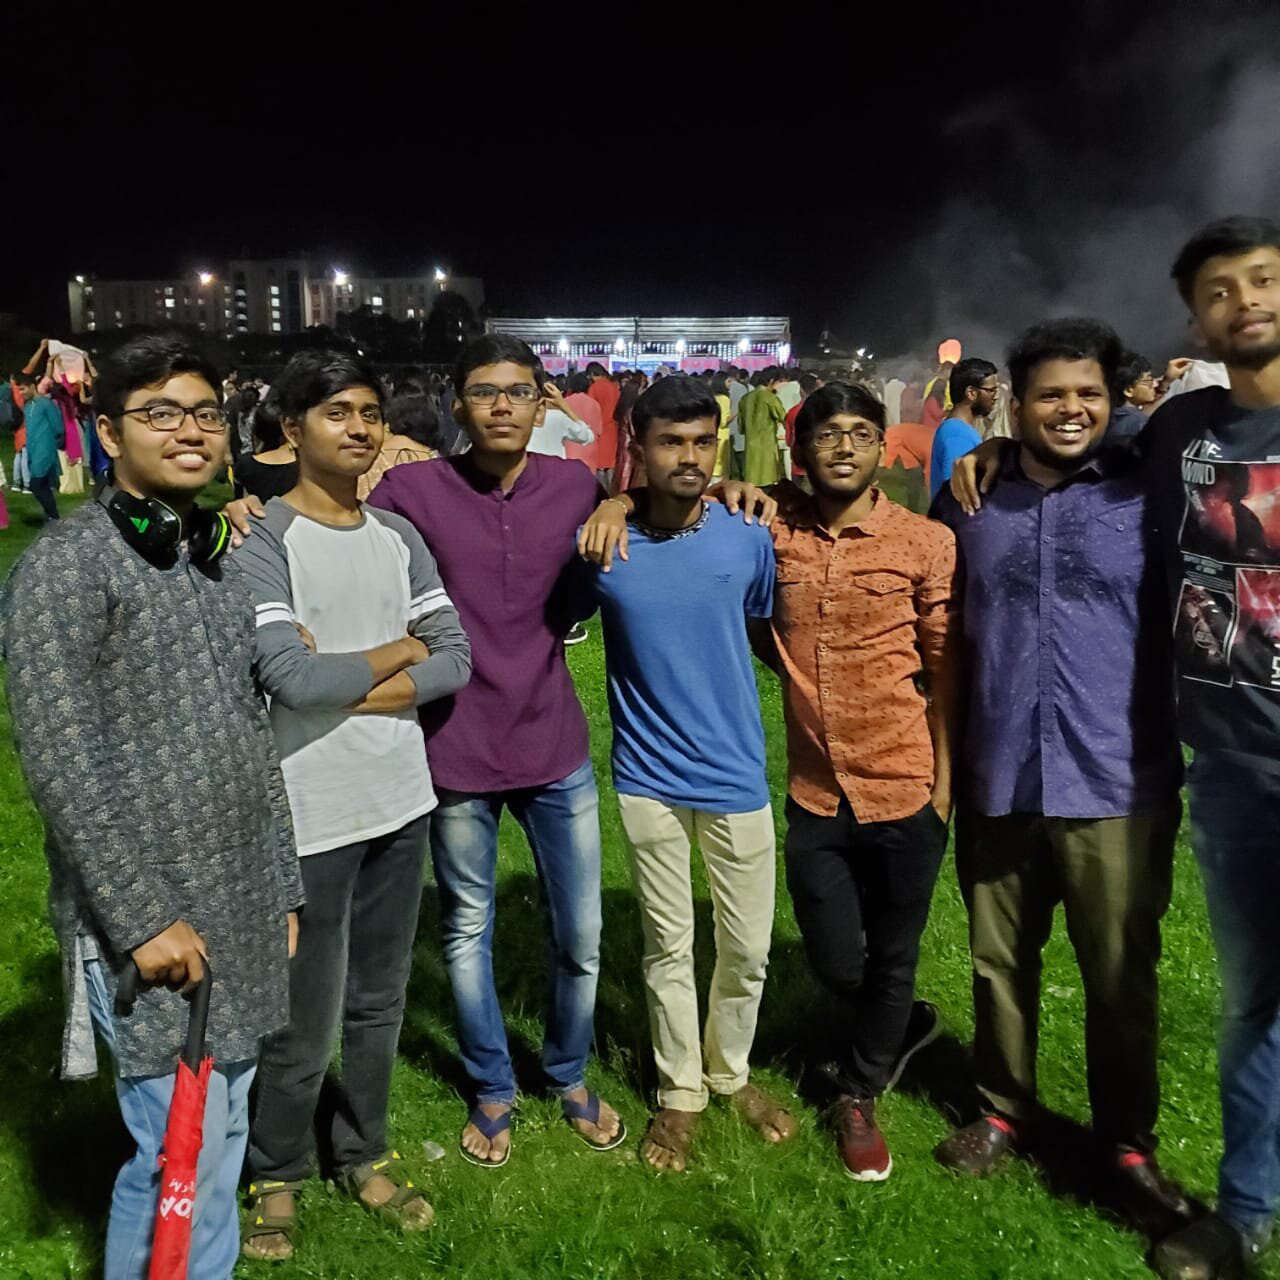

In [ ]:
image_path='C:/Users/Hp/python/RKPgroup.jpg'
caption_generated, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(caption_generated))
plot(image_path, caption_generated, plot_attention)
# opening the image
Image.open(image_path)

Prediction Caption: bike racer jumping bicycle outdoors taking drink ramp on bike <end>


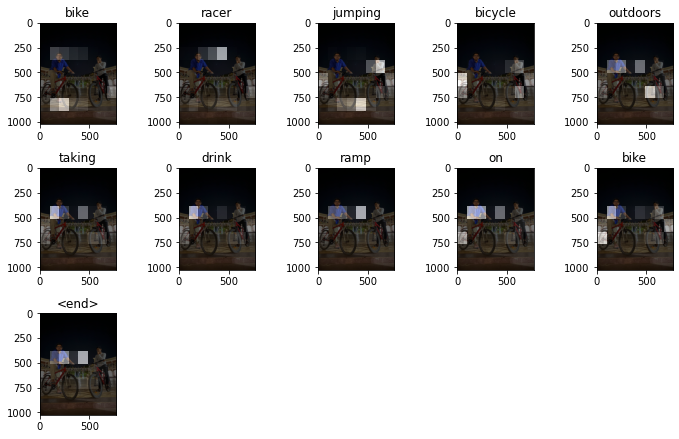

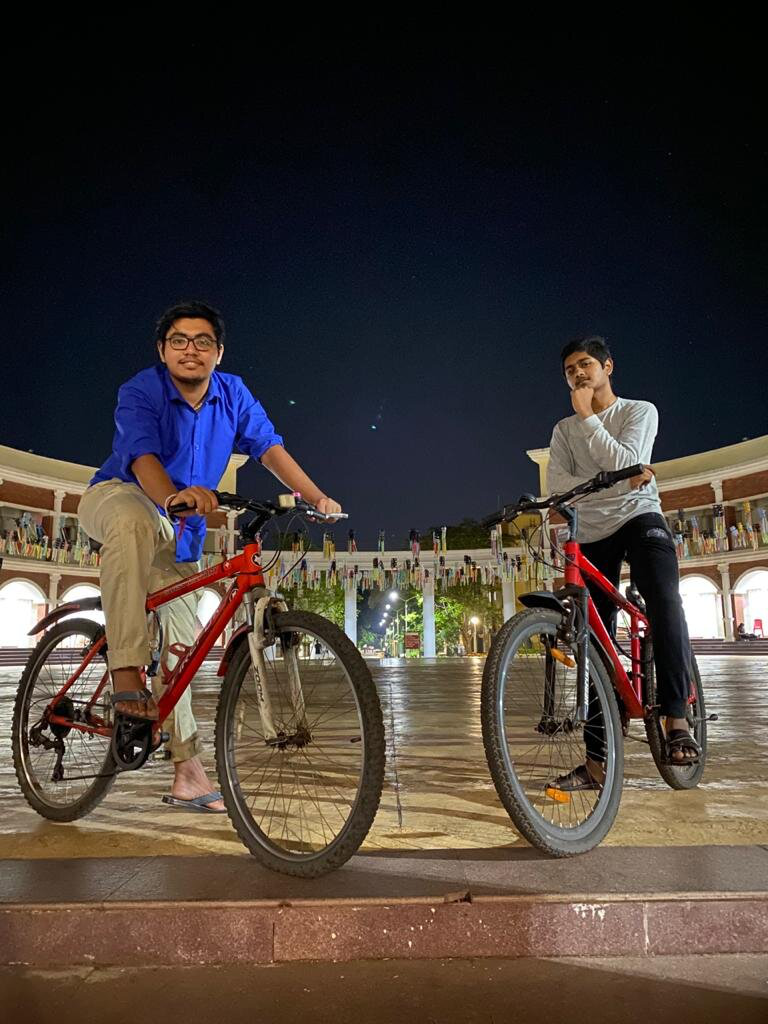

In [ ]:
image_path='C:/Users/Hp/python/ghanashyamcycle.jpg'
caption_generated, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(caption_generated))
plot(image_path, caption_generated, plot_attention)
# opening the image
Image.open(image_path)

## Experimenting the model with new images:
from the internet

131072/122927 [===============================] - 0s 4us/step
Prediction Caption: woman dancing piece of an elegant costumes <end>


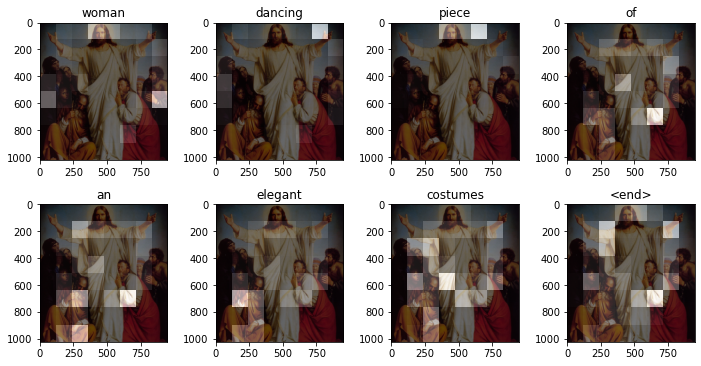

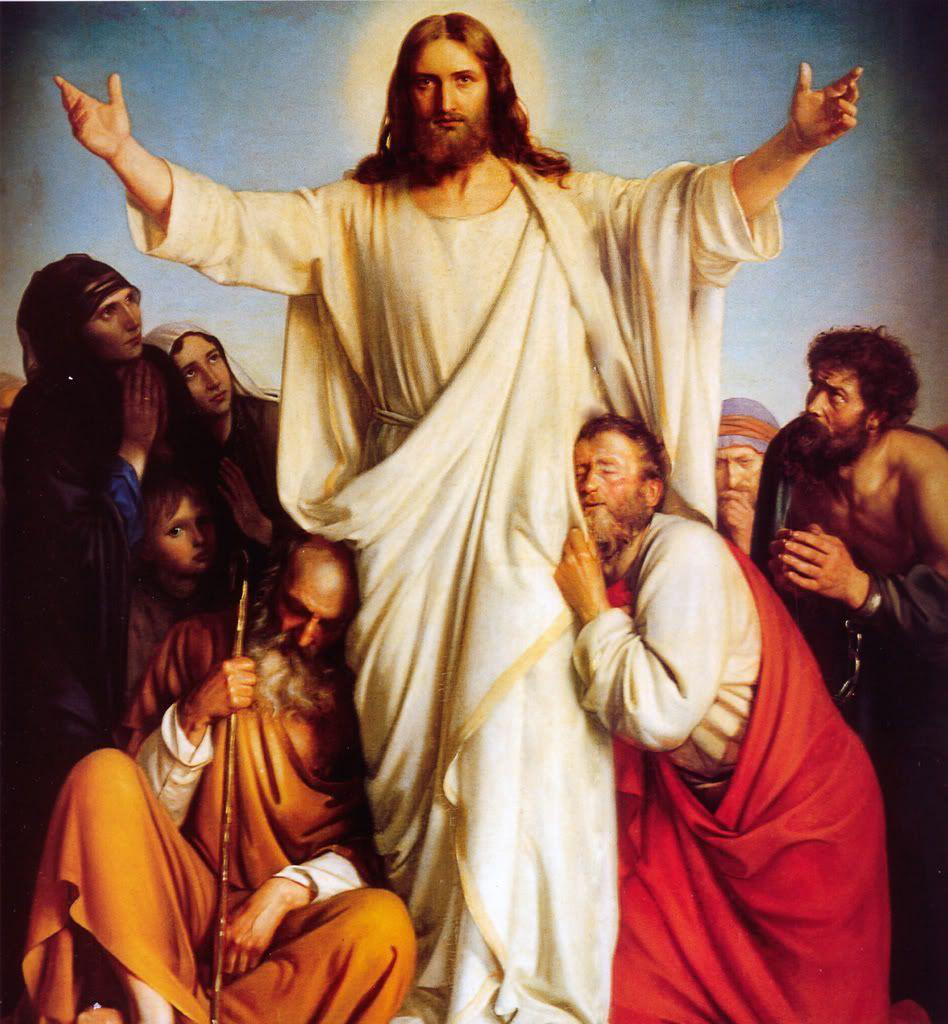

In [ ]:
image_url = 'https://wallpapercave.com/wp/GXaRv2X.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('jesus'+image_extension,
                                     origin=image_url)

result, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(result))
plot(image_path, result, plot_attention)
# opening the image
Image.open(image_path)

139264/132593 [===============================] - 1s 5us/step
Prediction Caption: the white dog wearing colored checkered collar jumps in the low cut out of dirt <end>


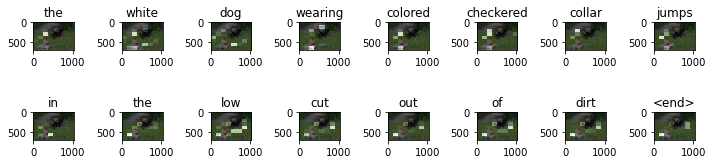

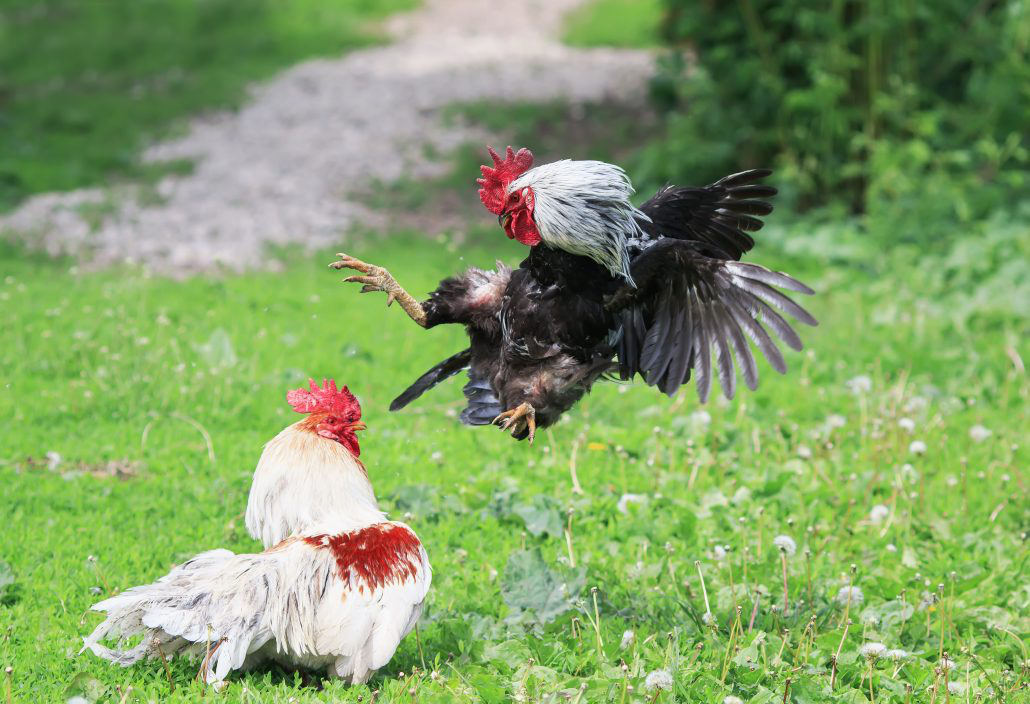

In [ ]:
image_url = 'https://www.pegasusfoundation.org/wp-content/uploads/2018/11/Fighting-Animals-1030x704.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('chickens'+image_extension,
                                     origin=image_url)

caption_generated, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(caption_generated))
plot(image_path, caption_generated, plot_attention)
# opening the image
Image.open(image_path)

Prediction Caption: people playing cricket <end>


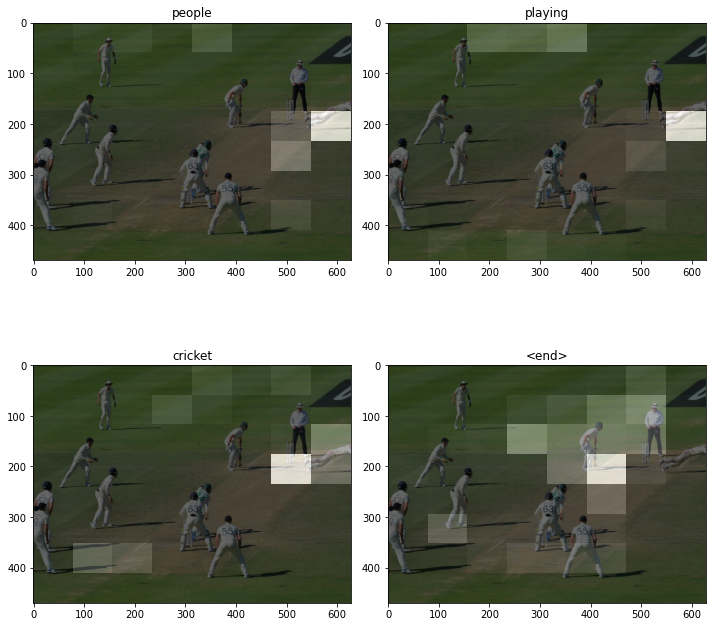

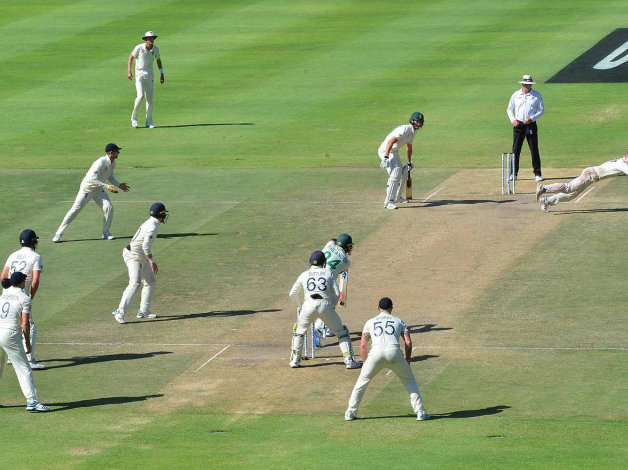

In [ ]:
image_url = 'https://barmytravel.com/sites/barmytravel.com/files/styles/event-hero/public/xgettyimages-1192401900-web.jpg,qitok=RTMkPtU5.pagespeed.ic.UlkLLaSAb6.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('cricket'+image_extension,
                                     origin=image_url)

caption_generated, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(caption_generated))
plot(image_path, caption_generated, plot_attention)
# opening the image
Image.open(image_path)

In [ ]:
image_url = 'https://barmytravel.com/sites/barmytravel.com/files/styles/event-hero/public/xgettyimages-1192401900-web.jpg,qitok=RTMkPtU5.pagespeed.ic.UlkLLaSAb6.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('img3'+image_extension,
                                     origin=image_url)

caption_generated, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(caption_generated))
plot(image_path, caption_generated, plot_attention)
# opening the image
Image.open(image_path)

Prediction Caption: the little boy in blue uniform jumping in field with girl in the grass <end>


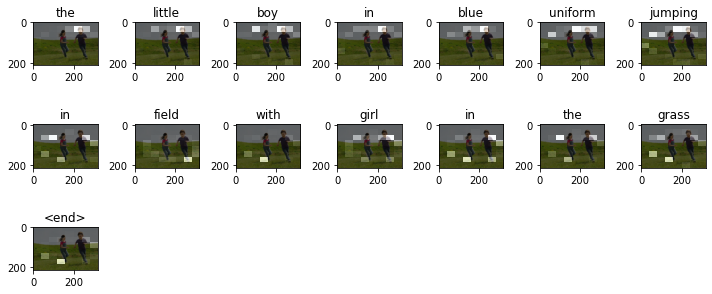

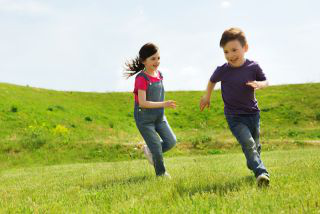

In [ ]:
image_url = 'https://cdn.mos.cms.futurecdn.net/3DCULvvXKrsqSNMxoW39sH-320-80.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image4'+image_extension,
                                     origin=image_url)

result, plot_attention = getcaption(image_path)
print ('Prediction Caption:', ' '.join(result))
plot(image_path, result, plot_attention)
# opening the image
Image.open(image_path)